In [1]:
%matplotlib ipympl
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

Get to know data

In [2]:
data = np.load("../data/jica_datarequest_nr0.npz")
data.files

['pipeline_version', 'dataproductnr', 'time', 'p1p2m1m2']

In [3]:
print('Product nummer', data['dataproductnr'])
print('pipeline version', data['pipeline_version'])
print('time', data['time'].shape)
print('p1p2m1m2', data['p1p2m1m2'].shape)

Product nummer 50
pipeline version 2.0
time (62,)
p1p2m1m2 (64, 62)


# Energy spectogram


last time at: -112.0


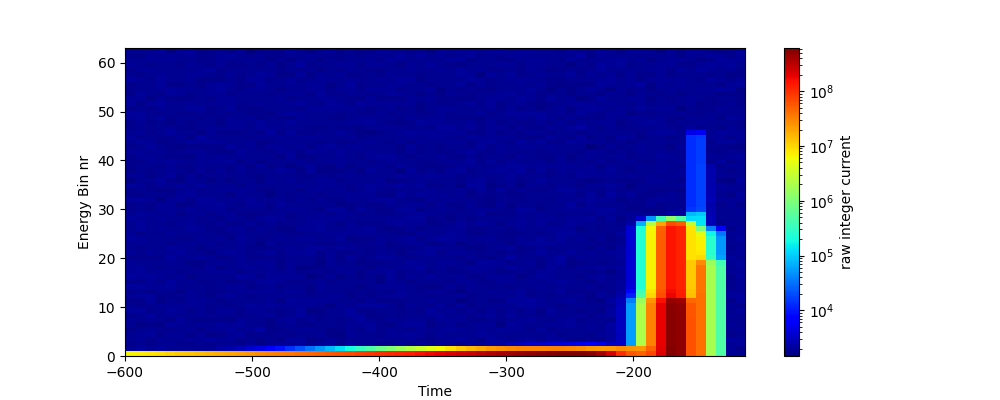

In [4]:
time = data['time']  
print("last time at:", time[-1])
e_bins = np.arange(64)  
ej_spec = data['p1p2m1m2']

from matplotlib.colors import LogNorm
fig, ax = plt.subplots(figsize=(10, 4))

im = ax.imshow(
    ej_spec,
    aspect='auto',
    origin='lower',
    extent=[time[0], time[-1], e_bins[0], e_bins[-1]],
    norm=LogNorm(),
    cmap='jet'
)
fig.colorbar(im, ax=ax, label="raw integer current")
ax.set_xlabel("Time")
ax.set_ylabel("Energy Bin nr")
plt.show()

## reduce input from bins above

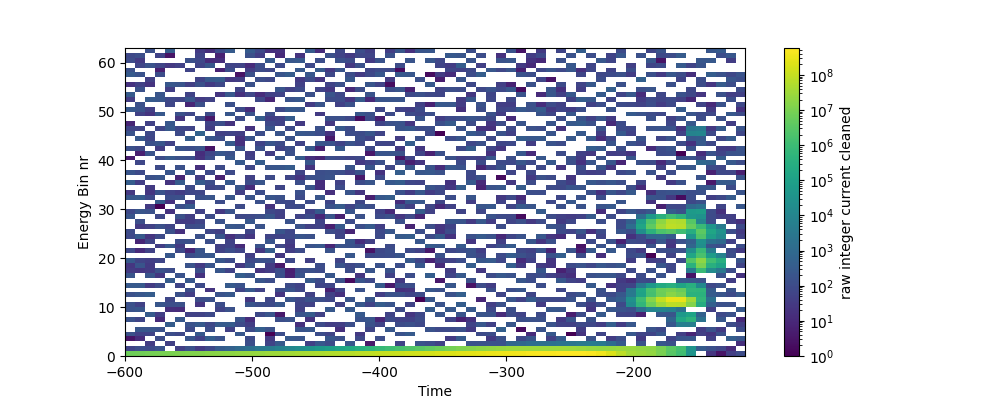

In [5]:
ej_c = ej_spec[:-1, :] - ej_spec[1:, :] # clean ej spec because the detector just includes all energies above bin in that bin
fig, ax = plt.subplots(figsize=(10, 4))

im = ax.imshow(
    ej_c,
    aspect='auto',
    origin='lower',
    extent=[time[0], time[-1], e_bins[0], e_bins[-1]],
    norm=LogNorm(),
    cmap='viridis'
)
fig.colorbar(im, ax=ax, label="raw integer current cleaned")
ax.set_xlabel("Time")
ax.set_ylabel("Energy Bin nr")
plt.show()

## gaussian noise removal
During ground calibration it was noted that the reported value for the current contains a small amount of uncorrelated noise. It is recommended to investigate this noise level from inflight data
- investigate noise

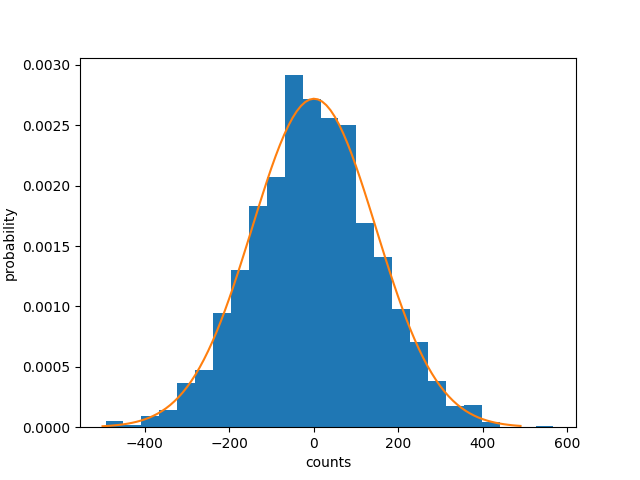

In [6]:
plt.close('all')
# find mean and stddev assuming gaussian noise
#mean_cts = np.mean(ej_c)
#std_cts = np.std(ej_c)
#print(f"Mean counts: {mean_cts:.2f}, Std counts: {std_cts:.2f}")
# make array with counts
counts = ej_c[10:, :45].flatten()
plt.hist(counts, bins=25, density=True)
plt.xlabel('counts')
plt.ylabel('probability')
x = np.arange(-500, 500, 10)
count_dist = stats.norm(counts.mean(), counts.std()).pdf(x)
plt.plot(x, count_dist)
#plt.vlines(mean_cts, ymin=0, ymax=np.max(count_dist), label='mean from all')
plt.show()

In [7]:
# subtract noise mean from data 
# and exclude data that is smaller than 3 stddev
ej_cleaned = ej_c - counts.mean()
print(ej_cleaned.shape)
ej_cleaned[ej_cleaned < 3 * counts.std()] = 0
print(ej_cleaned.shape)

(63, 62)
(63, 62)


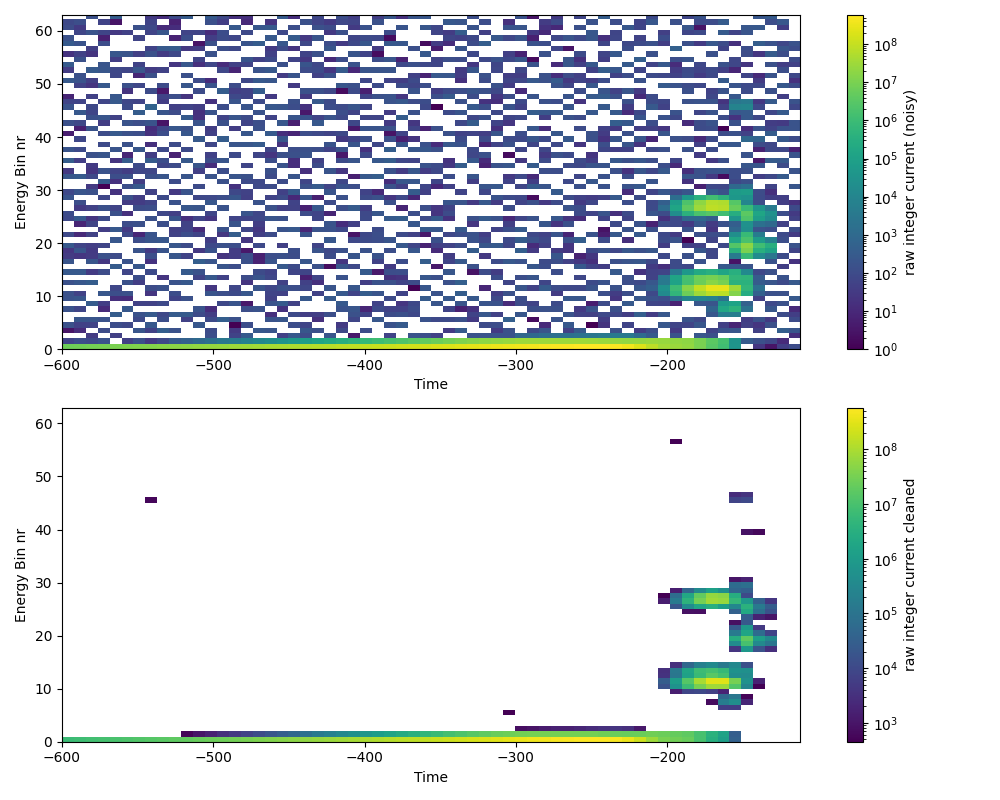

In [8]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(10, 8))

im = ax[0].imshow(
    ej_c,
    aspect='auto',
    origin='lower',
    extent=[time[0], time[-1], e_bins[0], e_bins[-1]],
    norm=LogNorm(),
    cmap='viridis'
)
fig.colorbar(im, ax=ax[0], label="raw integer current (noisy)")
ax[0].set_xlabel("Time")
ax[0].set_ylabel("Energy Bin nr")

im = ax[1].imshow(
    ej_cleaned,
    aspect='auto',
    origin='lower',
    extent=[time[0], time[-1], e_bins[0], e_bins[-1]],
    norm=LogNorm(),
    cmap='viridis'
)
fig.colorbar(im, ax=ax[1], label="raw integer current cleaned")
ax[1].set_xlabel("Time")
ax[1].set_ylabel("Energy Bin nr")

plt.tight_layout()
fig.savefig('figs/noise_removal_ba.png')
plt.show()

experiment with bins

In [ ]:
plt.close('all')


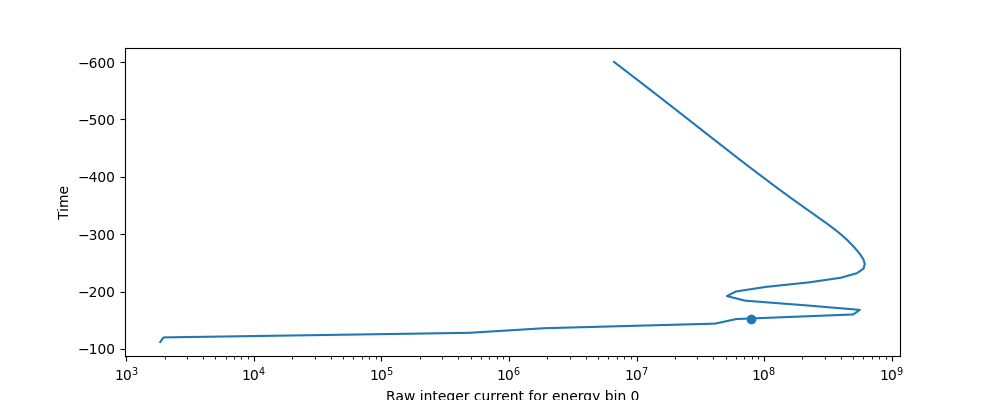

In [ ]:
fig, bx = plt.subplots(figsize=(10, 4))
bx.plot(ej_spec[0, :], time)  # Example for energy bin 0, not cleaned
bx.scatter(7.92e7, -152)
bx.set_xlabel("Raw integer current for energy bin 0")
bx.set_xscale("log")
bx.set_ylabel("Time")
fig.gca().invert_yaxis()

# this probably shows hydrogen data

# Notes on this
- time(current) data shows similarity to h1 in fig1 of description since lowest energy is mainly h1
- energy(time) shows energy and current increase around time = -200
    - possibly other ions start appearing, might indicate entering an atmosphere
- last time bin at -112
    - ROI is within [-200; -112]

# look at energy calibration txt

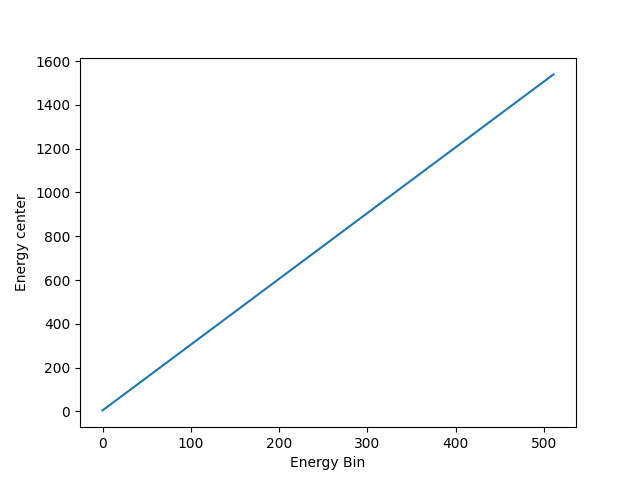

In [ ]:
plt.close('all')

data2 = np.loadtxt("../data/energy_calibration_jica.txt")
bins = data2[:,0]
energy = data2[:,1]
plt.plot(bins, energy)
plt.xlabel('Energy Bin')
plt.ylabel('Energy center')
plt.show()

Idea:
- fit random line through the time(raw integer current) data
- use the fit function * some factor to the model data in [model analysis](./test_ions/)